

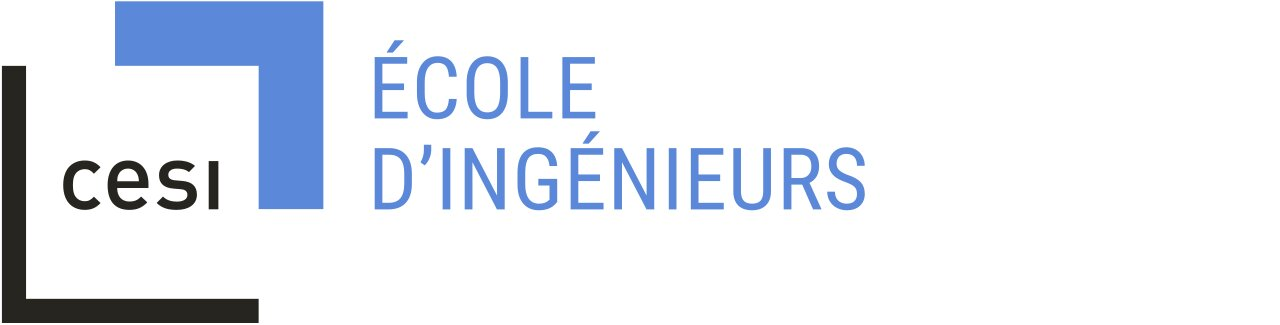
# Projet Leyenda
## Livrable 3 - Annotations d'images
|Auteurs|
|---|
|Karim Salhi
|Corentin Devrouete
|Hugo Larose
|Pierre-Alain Tietz


L'objectif de ce livrable est de faire du captionning  d'un photographie.
### Importation des librairies,
Dans un premier temps nous allons importer toutes les libraires nécessaire à notre débruitage :
- **Keras**, la bibliothèque Keras permet d'interagir avec les algorithmes de réseaux de neurones profonds et d'apprentissage automatique, notamment Tensorflow.
- **Tensorflow**, TensorFlow est un outil open source d'apprentissage automatique développé par Google.
- **Numpy**, NumPy est une bibliothèque pour langage de programmation Python, destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
- **Matplotlib**, est une bibliothèque utilisée pour tracer et visualiser des données à l'aide de graphiques.
- **Scikit-Learn**, est une bibliothèque utilisée pour l'apprentissage automatique et l'analyse de métriques
- **OpenCV** est une bibliothèque utilisée pour du traitement d'images.
- **Tqdm** est une bibliothèque utilisée pour visualiser des progress bar configurables"

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm

### Prétraitement des données 

Comme nous l'avons expliqué dans les différents livrables nous devons passer par une phase de prétraitement pour pouvoir créer un dataset optimal pour entrainer notre modèle. Pour ce faire, nous utiliserons le dataset MS COCO pour l'entrainement de notre modèle. Ce dataset publié par microsoft signfie Common Objects in Context, il est massivement utilisé dans le domaine de la vision par ordinateur. Du fait qu'il contient un grand nombre d'images étiquettées.

<b>Chargement des données</b>

Nous devons dans un premier temps charger les données du dataset COCO. Nous avons deux types de données dans ce cas, les images ainsi que les annotations.

2000
<start> A man with baskets of goods stands next to his bicycle.  <end>


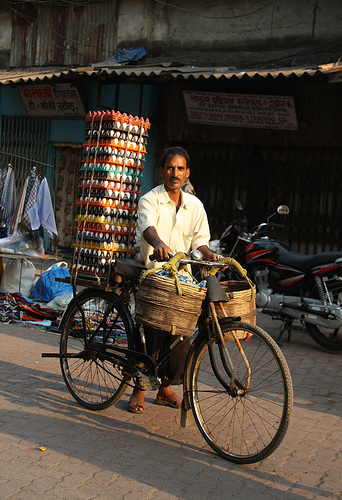

In [2]:
# Chemin du fichier d'annotations
annotation_folder = "../input/ms-coco/annotations_trainval2014/annotations/"
annotation_file = annotation_folder+"captions_train2014.json"
 
# Chemin du dossier contenant les images à annoter
image_folder = "../input/ms-coco/train2014/train2014/"
PATH = image_folder
 

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
 
# Grouper toutes les annotations ayant le meme identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    # marquer le debut et la fin de chaque annotation
    caption = f"<start> {val['caption']} <end>"
    # L'identifiant d'une image fait partie de son chemin d'accès
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    # Rajout du caption associé à image_path
    image_path_to_caption[image_path].append(caption)

# Prendre les 2000 premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]
print(len(train_image_paths))
 
# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []
 
for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    # Rajout de caption_list dans train_captions
    train_captions.extend(caption_list)
    # Rajout de image_path dupliquée len(caption_list) fois
    img_name_vector.extend([image_path] * len(caption_list)) #SOLUTION
    
print(train_captions[666])
Image.open(img_name_vector[666])

### Traitement des images

Maintenant que nous avons chargé nos données dans le bon format nous pouvons nous pencher sur leur prétraitement. Dans cette partie nous nous intéresserons au cas des images. Dans l'état actuel ce type de données n'est pas adéquat pour entrainer notre modèle. Nous devons par conséquent les transformer pour qu'elles puissent être interprétables comme entrée pour notre modèle final.<br>

Nous devrons par conséquent encoder nos images sous forme de vecteur. Nous avons déjà vu ce principe avec la convolution dans les précédents livrables.<br>

Dans le but de permettre au réseau de converger plus rapidement et de n'avoir à entraîner que le modèle final, nous avons décidé d'utiliser la méthode de **transfer learning**. Pour ce faire nous avons directement implémenté le modèle **InceptionV3** pré-entrainé sur ImageNet.<br>

Les poids du modèle sont gelés ce qui signifie que le modèle n'apprend plus et ne fait que de traiter les données que nous lui fournissons. De plus, lors de la dernière couche du modèle la taille de l'image est de la forme (8, 8, 2048). Durant le stockage en mémoire nous redimensionnons ce vecteur de la forme suivante : (64, 2048). Ce qui veut dire que pour chaucune des 64 positions de l'image prétraitée, 2048 caractéristiques ont été extraites par InveptoinV3. Et par conséquent, l’entrée du décodeur CNN est un batch ou chaque élément est constitué des 2048 caractéristiques des 64 positions de l’image prétraitée.

La fonction <strong>load_image</strong> a pour entrée le chemin d'une image et pour sortie un couple contenant l'image traitée ainsi que son chemin d'accès

In [3]:
# Telechargement du modèle InceptionV3 pré-entrainé avec la cassification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
# Creation d'une variable qui sera l'entrée du nouveau modèle de pre-traitement d'images
new_input = image_model.input 
# récupérer la dernière couche caché qui contient l'image en representation compacte
hidden_layer = image_model.layers[-1].output
 
# Modèle qui calcule une representation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
 
# Définition de la fonction load_image
def load_image(image_path):
    """
    La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
    contenant l'image traitée ainsi que son chemin d'accès.
    La fonction load_image effectue les traitement suivant:
        1. Chargement du fichier correspondant au chemin d'accès image_path
        2. Décodage de l'image en RGB.
        3. Redimensionnement de l'image en taille (299, 299).
        4. Normalisation des pîxels de l'image entre -1 et 1
    """
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path
 
# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))
 
# Creation d'une instance de "tf.data.Dataset" partant des noms des images 
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# Division du données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

2022-01-19 09:55:33.661199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 09:55:33.794079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 09:55:33.795437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 09:55:33.797610: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

87924736/87910968 [==============================] - 1s 0us/step


In [4]:
for img, targ in image_dataset.take(1):
    #print(img)
    print(targ)

2022-01-19 09:55:40.181675: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


tf.Tensor(
[b'../input/ms-coco/train2014/train2014/COCO_train2014_000000000560.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000000562.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000001145.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000001298.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000001307.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000001355.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002024.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002083.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002296.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002448.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002664.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002776.jpg'
 b'../input/ms-coco/train2014/train2014/COCO_train2014_000000002860.jpg'
 b'../input/ms-coco/train2014/train2014/

### Traitement des annotations

Une fois nos images traitées nous pouvons nous concentrer sur nos annotations. Comme pour les images nous devons transformer notre jeu de données. 

Dans le code ci-dessous nous avons réalisé un traitement en nombre entier grâce à la classe tokenizer de tensorflow.

In [5]:
# Trouver la taille maximale 
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
 
# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)
 
# Créer le token qui sert à remplir les annotations pour egaliser leurs longueur
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
 
# Creation des vecteurs(liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)
 
# Remplir chaque vecteur jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
 
# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention 
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

print(max_length)

33


### Préparation du jeu d'entrainement et de test :

Voila nos donnés prétraitées. Dans cette partie nous faisons la création des différents datasets à partir de ces nouvelles données.<br>

Pour préparer le jeu de données, nous le séparons en deux sous-ensembles homogènes afin d'éviter la sous-représentation de classe. Le premier sous-ensemble, dit d'entraînement, permettra au modèle d'ajuster ses poids et par conséquent améliorer son débruitage. Le second nous permet d'évaluer la capacité du modèle à débruiter.

In [6]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant 
un fractionnement 80-20 de manière aléatoire
""" 
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len =len(img_to_cap_vector[imgv]) \
    # Duplication des images en le nombre d'annotations par image
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

10005 10005


(8005, 8005, 2000, 2000)

Nous avons, dans ce contexte, un jeu de données volumineux. Ainsi la classe `tf.data.Dataset` sert à représenter des jeu de données volumineux et facilitent les prétraitements de ceux-ci.

In [7]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 64 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
 
# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64
 
# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor = np.load("../input/ms-coco/preprocessed_images/preprocessed_images/" + os.path.split(img_name.decode('utf-8'))[-1] + '.npy')
    return img_tensor, cap
 
# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
 
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
 
# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
 
# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(dataset.take(1))

<TakeDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>


### Création du modèle :


Nous avons maintenant un dataset propre et prêt à être exploité pour l'entraînement. Par conséquent cette partie est axée sur le développement et l'évaluation du modèle.

#### Le RNN (Recurrent Neural Network)

Pour répondre aux différentes contraintes que nous avons énoncé plus haut, nous avons décidé d'implémenter un réseau de neurones récurrents. En effet, le RNN est une classe de réseaux de neurones artificiels où les connexions entre les nœuds forment un graphe orienté le long d'une séquence temporelle. Cela lui permet de présenter un comportement dynamique temporel. Dérivés des réseaux de neurones prédictifs, les RNN peuvent utiliser leur état interne (mémoire) pour traiter des séquences d'entrées de longueur variable. Pour donner un meilleur aperçu une représentation est visible ci-dessous :

![RNN.PNG](./photo_livrable/rnn.png)


#### Solution 

Ci-dessous nous avons repésenté le schéma final de la solution. Nous avons déjà parlé du modèle pré-entrainé Inception V3 précedement dans ce notebook. Nous décrirons et implémenterons les autres parties du schéma dans la suite de ce dernier.

![Modele_final.png](./photo_livrable/solution.png)

#### L'encodeur CNN :

Le rôle de de l'encodeur est de produire une représentation vectorielle de l'image qui sera passée comme input au décodeur RNN. Le CNN va prendre les cractéristiques extraites par InceptionV3 et stockées sur disque.<br>

Pour rappel, nous avions utilisé la technique du transfer learning précedement pour prétraiter nos inputs. Pour entrainer le modèle sur notre problème nous rajoutons une couche dense à la fin. Cette dernière couche dense  calcule une nouvelle représentation de l’image de taille 64 x 256 ou chaque position de l’image a donc 256 caractéristiques. De plus nous n'effectuons pas d'aplatissment au cours de notre traitement.<br> 

L’avantage de cette représentation par rapport à la représentation aplatie est de préserver de l’information spatiale au niveau des couches du réseau de neurones. Ceci permettra au mécanisme d’attention de la partie RNN de détecter les positions intéressantes au niveau de l’image et de renseigner l’algorithme sur quelle zone il devra porter le plus d’importance pour légender l’image. <br>

In [8]:
class CNN_Encoder(tf.keras.Model):
    # Comme les images sont déjà prétraités par InceptionV3 est représenté sous forme compacte
    # L'encodeur CNN ne fera que transmettre ces caractéristiques à une couche dense
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # forme après fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
 
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Le mécanisme d'attention :

Le mécanisme d’attention ressemble beaucoup à une cellule RNN classique, mais avec quelques différences. La partie de l’attention a en entrée la représentation de l’image prétraitée retournée par le CNN ainsi que la valeur courante de l’état cachée du GRU, et en sortie le **vecteur du contexte** qui reflète les caractéristiques les plus importantes de l’image. Une étape intermédiaire pour calculer ce vecteur consiste à calculer les **poids d’attention** qui représentent l’importance de chaque position de l’image (il y en a 64) dans la prédiction de son annotation.

La représentation de l’image donnée en entrée est transformée au début de la même manière que pour le CNN en la passant à une couche dense de taille `units`. De même, l’état caché est aussi passé à une couche dense de taille `units`. La nouvelle représentation de l’image est ensuite additionnée à l’état caché puis passée à une fonction d’activation de type `tanh` comme pour les cellules classiques de RNN. À ce niveau-là, on aura une représentation des données de taille `64xunits` contenant un mélange d’informations sur l’image et sur le texte de l’annotation. Un score est ensuite associé à chacune des positions en passant cette représentation à une couche dense. Ces scores sont normalisés avec une couche softmax pour produire le vecteur des **poids d’attention**. 

Finalement, chaque caractéristique de la représentation de l’image en entrée sera multipliée (pondérée) par le vecteur d’attention. Après quoi, on prend la somme de chaque caractéristique le long des positions (les lignes de la représentation) pour former le **vecteur du contexte**.

De façon globale, on peut dire que le vecteur d’attention dépend de scores qui sont appris à partir d’une représentation spatiale et textuelle de l’image. Ce vecteur d’attention renvoie la pertinence de chaque position et sert à calculer le vecteur du contexte qui nous donnera l’importance des caractéristiques de l’image.

In [9]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
 
    def call(self, features, hidden):
        # features(CNN_encoder output) forme == (batch_size, 64, embedding_dim)
 
        # forme de la couche cachée == (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) 
 
        attention_hidden_layer = (tf.nn.tanh(self.W1(features)+self.W2(hidden_with_time_axis)))
 
        # Cela vous donne un score non normalisé pour chaque caractéristique de l'image.
        score = self.V(attention_hidden_layer) 
 
        attention_weights = tf.nn.softmax(score, axis=1) 
 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Le décodeur RNN :

Le rôle du décodeur RNN est d’utiliser la représentation prétraitée de l’image de prédire sa légende mot par mot. Ce RNN à une seule cellule de type GRU. Le GRU a un état caché qui représente la mémoire des derniers éléments vu par celui-ci. Le GRU met à jour son état avant de le retourner, pour cela il utilise certains mécanismes de mémorisation qui sont assez sophistiqués.

Le décodeur est structuré comme suit, à chaque appel du RNN, le mot courant ainsi que la représentation de l’image et l’état caché du GRU sont donnés en entrée du RNN. Comme les mots sont représentés par des entiers, on doit faire passer ceux-ci par une couche dite embedding layer qui se chargera de calculer une représentation vectorielle de taille `output_dim` partant du nombre représentant le mot. 

À côté de ça, le mécanisme d’attention fournit un vecteur représentant **le contexte** de l’image c-à-d un vecteur qui nous renseigne sur les caractéristiques dominantes de l’image. Ce vecteur est calculé par un appel du mécanisme d’attention en lui fournissant en entrée les caractéristiques de l’image encodées par le CNN ainsi que l’état caché du GRU qui résume l’historique des mots vues par le RNN jusqu’à présent. 

Ensuite, le mot courant et le contexte sont concaténée pour former le vecteur d’entrée du GRU qui à son tour calcule l’état à l’étape suivante. Cet état est passée par une couche dense de taille `units` puis la sortie de cette couche est passée à une autre couche dense de taille `vocab_size` qui retourne le score associé à chaque mot du vocabulaire afin de prédire le mot suivant.

In [10]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        #Couche dense qui aura pour entrée la sortie du GRU
        self.fc1 = tf.keras.layers.Dense(self.units)
        # Dernière couche dense
        self.fc2 = tf.keras.layers.Dense(vocab_size)
 
        self.attention = BahdanauAttention(self.units)
 
    def call(self, x, features, hidden):
        # L'attention est defini par un modèle a part
        context_vector, attention_weights = self.attention(features, hidden)
        # Passage du mot courant à la couche embedding
        x = self.embedding(x)
        # Concaténation
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
 
        # Passage du vecteur concaténé à la gru
        output, state = self.gru(x)

        # Couche dense
        y = self.fc1(output)
 
        y = tf.reshape(y, (-1, x.shape[2]))

        # Couche dense
        y = self.fc2(y)

        return y, state, attention_weights
 
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Combiner la partie encodeur et décodeur :

Pour finir nous combinons le modèle d'encodage (CNN) et de décodage (RNN)

In [11]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)
# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [12]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()
# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
 
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
 
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
 
    return tf.reduce_mean(loss_)

Pour garder la trace de l'apprentissage et la sauvegarder, on utilise la classe `tf.train.Checkpoint`

In [13]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

Initialisation de l'époque de début d’entrainement dans `start_epoch`. La classe `tf.train.Checkpoint` permet de poursuivre l’entrainement là ou vous l’avez laissé s’il avait été interrompu auparavant.

In [14]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

# Entrainement et test :
Pour entraîner et tester nos annotations nous avons implémentés 2 fonctions `train_step` et `evaluate` :

- La fonction `train_step` représente une étape de l'entrainement du réseau. Elle est composée de l'évaluation par l'encodeur du vecteur pré-calculé par InceptionV3. La sortie de cette étape sera transmise au décodeur qui se charge de prédire l'annotation mot par mot. La boucle pour prédire chaque mot et calculer la perte associée  est implémenté dans cette fonction.
- La fonction `evaluate` servira à évaluer les performances du réseau sur le jeu de test. Elle est donc similaire à la fonction `train_step` sauf que la partie calcul de la fonction de perte est absente car il n'agit pas d'entrainer le réseau.</li>

Nous implémenterons ensuite la partie d'entraînement par batch d'image.

# Entrainement
La fonction qui permet d'achever une étape d'entrainement sur un batch d'images est `train_step`. La fonction a en entrée un batch d'images prétraitées ainsi que leurs annotations et retourne la perte associée à ce batch. 

L'état caché de la partie RNN est initialisé ainsi que le mot de départ avec le token de début. Les caractéristiques de l'image sont ensuite extraites par l’encodeur. Après cela, on parcourt le batch mot par mot pour prédire le mot suivant à l'aide du décodeur. Le décodeur utilise l'état caché, les caractéristiques de l'image ainsi que le mot précédent pour prédire le mot courant. Le décodeur met à jour l'état caché et le retourne ainsi que les prédictions du batch. La perte est calculée à partir des prédictions retournées par le décodeur et les annotations associées au batch.

Finalement, la perte globale ainsi que le gradient sont calculés et le réseau est mis à jour.

In [15]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Le mot correct à l'étap i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

Le code global contenant la boucle d'entrainement est présenté ci-dessous. Cette boucle parcours le jeu de données d'entrainement batch par batch et entraine le réseaux avec ceux-ci.

2022-01-19 09:56:34.896247: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch 1 Batch 0 Loss 2.8191
Epoch 1 Batch 100 Loss 1.5916
Epoch 1 Loss 1.732133
Time taken for 1 epoch 108.69215226173401 sec

Epoch 2 Batch 0 Loss 1.5499
Epoch 2 Batch 100 Loss 1.3401
Epoch 2 Loss 1.380800
Time taken for 1 epoch 18.941465139389038 sec

Epoch 3 Batch 0 Loss 1.3157
Epoch 3 Batch 100 Loss 1.1403
Epoch 3 Loss 1.250425
Time taken for 1 epoch 18.126317977905273 sec

Epoch 4 Batch 0 Loss 1.2047
Epoch 4 Batch 100 Loss 1.1222
Epoch 4 Loss 1.149516
Time taken for 1 epoch 17.97087287902832 sec

Epoch 5 Batch 0 Loss 1.1013
Epoch 5 Batch 100 Loss 1.0215
Epoch 5 Loss 1.067010
Time taken for 1 epoch 18.456283569335938 sec

Epoch 6 Batch 0 Loss 1.0462
Epoch 6 Batch 100 Loss 0.8958
Epoch 6 Loss 0.996607
Time taken for 1 epoch 19.52520489692688 sec

Epoch 7 Batch 0 Loss 1.0415
Epoch 7 Batch 100 Loss 0.9368
Epoch 7 Loss 0.939068
Time taken for 1 epoch 17.88166570663452 sec

Epoch 8 Batch 0 Loss 0.8983
Epoch 8 Batch 100 Loss 0.9432
Epoch 8 Loss 0.882963
Time taken for 1 epoch 18.50275683

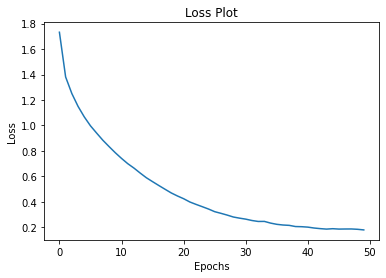

In [16]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Test
La fonction qui permet d'achever une étape d'evaluation pour le test est dans la cellule suivante. 
La fonction `plot_attention` permet d'afficher l'attention porté sur une zone de l'image par notre modèle.

In [17]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

### Exemple

Nous allons ici comparés nos annotations prédites avec les annotations réelles. Ce qui nous permetteras de voir si notre modèle est capable de prédire plus ou moins correctement des annotations.

Annotation réel: <start> a woman riding a bicycle holding an umbrella <end>
Annotation prédite: a woman with her pink umbrella <end>


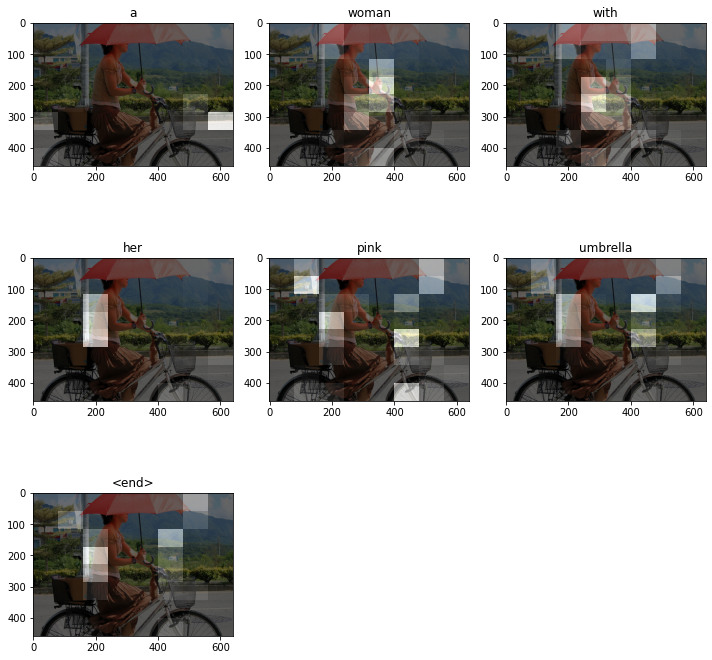

download successful


In [18]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Annotation réel:', real_caption)
print ('Annotation prédite:', ' '.join(result))
plot_attention(image, result, attention_plot)
Image.open(image)

import urllib.request

urllib.request.urlretrieve("https://s2.qwant.com/thumbr/0x380/6/f/782a1fee869b8012e59b6c79cce6612607bd7a6b05dd76d1871441c5469062/chat-2.jpg?u=https%3A%2F%2Fwww.animotopia.com%2Fwp-content%2Fuploads%2F2017%2F01%2Fchat-2.jpg&q=0&b=1&p=0&a=0",
"chat.jpg")

print("download successful")

## Utilisation sur un autre jeu de données

Nous allons ici annoter les images contenues dans un autre jeu de données 

Nous téléchargons d'abord des images pour remplir notre de jeu de données de test

In [ ]:
import urllib.request

urllib.request.urlretrieve("https://s2.qwant.com/thumbr/0x380/6/f/782a1fee869b8012e59b6c79cce6612607bd7a6b05dd76d1871441c5469062/chat-2.jpg?u=https%3A%2F%2Fwww.animotopia.com%2Fwp-content%2Fuploads%2F2017%2F01%2Fchat-2.jpg&q=0&b=1&p=0&a=0",
"chat.jpg")

![](https://s2.qwant.com/thumbr/0x380/6/f/782a1fee869b8012e59b6c79cce6612607bd7a6b05dd76d1871441c5469062/chat-2.jpg?u=https%3A%2F%2Fwww.animotopia.com%2Fwp-content%2Fuploads%2F2017%2F01%2Fchat-2.jpg&q=0&b=1&p=0&a=0)

Une fois que le jeu de données contient des images, nous faisons une boucle qui annote chaque image du jeu de données

Annotation prédite: a cat sitting on a riverbank <end>


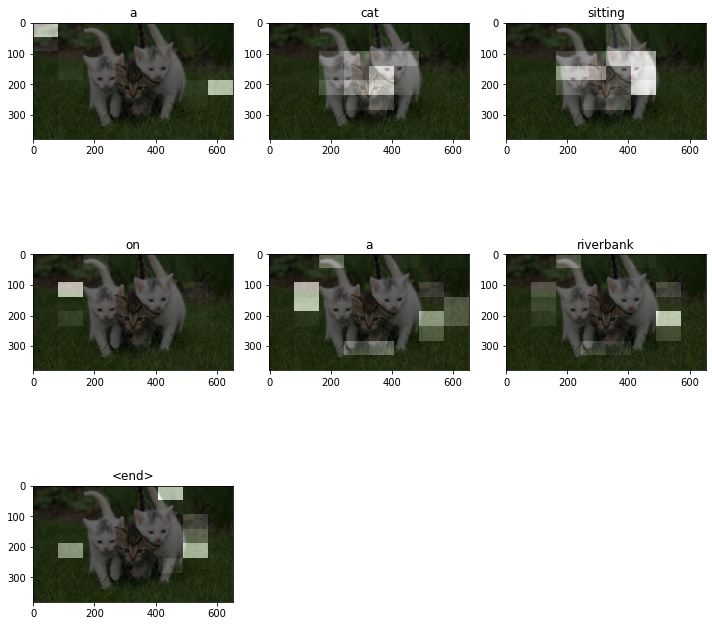

In [19]:
dataset = './'
for img in os.listdir(dataset):
    result2, attention_plot2 = evaluate(img)
    print ('Annotation prédite:', ' '.join(result2))
    plot_attention(img, result2, attention_plot2)

Nous pouvons voir les résultats sur le jeu de données ci-dessus.

### Conclusion

L'objectif de ce livrable était d'entrainer un modèle permettant d'annoter des photos en se basant sur les éléments la constituant. Nous avons donc dû créer un modèle capable de prendre en entrée des images et de générer des descriptions textuelles. <br>
Pour cela, nous avons choisi un modèle en deux parties, une produisant une représentation vectorielle de l'image par le biais du transfert learning issus d’InceptionV3, et la seconde pour générer des poids d’attention à partir de l’output du premier modèle. Dans le but, de créer une description mot par mot à l’image.<br>
Grâce à ce modèle on arrive donc à décrire textuellement nos photographies. Cependant l'image captioning est un domaine dans lequel, encore aujourd'hui, les modèles et techniques ne sont pas assez performants pour créer une légende semblable à une légende créée par un humain. <br>
Toutefois, certaines caractéristiques importantes de nos photographies arrivent à être reconnues et décrites par notre modèle, même si des améliorations sont toujours nécessaires.